<a href="https://colab.research.google.com/github/27septembre/QG_eff/blob/main/code/2_QG_pytorch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting

input data: data/outputs/

* training: data/training/00/  (generated by 1_qgm2_calc_eff_generate_training_data.ipynb)
* pred: data/preds/

if with noise:
*   training: data/noise_filtered/ (generated by 5_qgm2_calc_eff_generate_noise.ipynb)
*   pred: data/preds/

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# if running on Colab
!git clone https://github.com/27septembre/QG_eff/

Cloning into 'QG_eff'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 38 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), 63.93 MiB | 9.15 MiB/s, done.


In [3]:
# data location
# running locally
#data_dir='../data/'

# if running on Colab
data_dir='QG_eff/data/'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Preparation

## Data loaders

In [13]:
# NOTE: would be better to pull this out from qg_parameters.F90
layers, nx, ny = 3, 513, 513

Lx, Ly = 3840.0e5, 3840.0e5      # lengths (in cm)
scale = Lx / (nx - 1)               # scaling factor (T = L = sc)  #750000
x_vec, y_vec = np.linspace(0, Lx, nx), np.linspace(0, Ly, ny)
H = [0.25e5, 0.75e5, 3.0e5]      # layer depths (in cm)
avg_period = 5000.0 * 3600 * 24  # averaging period (*_int.data is time-integrated)
avg_period_nondim = avg_period / scale

In [14]:
#  adjust data location/
def read_data(varnn,nlyr,nre,fname,nl=0):
    if varnn =='div':
          if nl == 0:
            return np.load(data_dir+'training/%s/div_uq_%s_80.npy'%(nre,fname))[nlyr]
          else:
            return np.load(data_dir+'noise_filtered/div_uq_%s_80_noise%s.npy'%(fname,"{:02}".format(int(nl * 10))))[nlyr]
    elif varnn =='grad' or varnn =='uvq':
        if nl == 0:
            ff = np.load(data_dir+'training/%s/%s_%s_80.npz'%(nre,varnn,fname))
        else:
            ff = np.load(data_dir+'noise_filtered/%s_%s_80_noise%s.npz'%(varnn,fname,"{:02}".format(int(nl * 10))))
        return ff[ff.files[0]][nlyr],ff[ff.files[1]][nlyr]
    else:
        pp= np.fromfile(data_dir+'outputs/%s_int.dat'%(varnn),
                            dtype=np.float64).reshape(layers, nx, ny) / avg_period_nondim
        return pp[nlyr]

In [15]:
# divide into 40x40 patches
def get_data(var_1):
    nt=40
    var2= np.zeros( (100**2,nt,nt) )
    stride =6
    ni=0

    for i in range( 0, var_1.shape[1]-nt+1, stride):
        for j in range( 0, var_1.shape[0]-nt+1, stride ):
            var2[ni] = var_1[j:j+nt,i:i+nt]
            ni+=1
        if var_1.shape[0]-(j+nt) != 0:
            var2[ni] = var_1[-nt:var_1.shape[1],i:i+nt]
            ni+=1

    if var_1.shape[1]-(i+nt) != 0 :
        for j in range( 0, var_1.shape[0]-nt+1, stride ):   # loop through points in y
            var2[ni] = var_1[j:j+nt,-nt:var_1.shape[0]]
            ni+=1
        if var_1.shape[0]-(j+nt) != 0:
            var2[ni] = var_1[-nt:var_1.shape[1],i:i+nt]
            ni+=1

    var2=var2[:ni]
    return var2

In [16]:
# 1 input to 1 output
def load_dataT(p_1,s_1,rni,batchsize):
    nt=40

    mu1, sigma1 = np.mean( p_1 ), np.std( p_1 )
    mu2, sigma2 = np.mean( s_1 ), np.std( s_1 )
    scalings = [mu1, sigma1, mu2, sigma2]

    p_input = (p_1-mu1)/sigma1
    S_out = (s_1-mu2)/sigma2

    xTrain, xVal, yTrain, yVal= train_test_split( p_input, S_out, test_size=0.2, random_state=rni, shuffle=True)

    xTrain = np.reshape(xTrain, (-1,1, nt, nt))
    xVal = np.reshape(xVal, (-1, 1,nt, nt))

    yTrain = np.reshape(yTrain, (-1, nt * nt))  # For CNNs #1
    yVal = np.reshape(yVal, (-1, nt * nt))

    dataset = torch.utils.data.TensorDataset(torch.from_numpy(xTrain).float(),torch.from_numpy(yTrain).float())
    train_loader=torch.utils.data.DataLoader(dataset , batch_size=batchsize, shuffle=True, num_workers=2)
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(xVal).float(),torch.from_numpy(yVal).float())
    val_loader=torch.utils.data.DataLoader(dataset , batch_size=batchsize, shuffle=True, num_workers=2)

    return train_loader,val_loader, scalings

In [17]:
# 1 input to 2 outputs
def load_dataT2(p_1,s_1,s_2,rni,batchsize):
    nt=40

    mu1, sigma1 = np.mean( p_1 ), np.std( p_1 )
    mu2, sigma2 = np.mean( s_1 ), np.std( s_1 )
    mu3, sigma3 = np.mean( s_2 ), np.std( s_2 )
    scalings1 = [mu1, sigma1, mu2, sigma2]
    scalings2 = [mu1, sigma1, mu3, sigma3]

    p_input = (p_1-mu1)/sigma1
    s_out1 = (s_1-mu2)/sigma2
    s_out2 = (s_2-mu3)/sigma3
    S_out = np.stack((s_out1,s_out2),axis=3)

    xTrain, xVal, yTrain, yVal= train_test_split( p_input, S_out, test_size=0.2, random_state=rni, shuffle=True)

    xTrain = np.reshape(xTrain, (-1,1, nt, nt))
    xVal = np.reshape(xVal, (-1, 1,nt, nt))

    yTrain = np.reshape(yTrain, (-1, nt * nt*2))  # For CNNs #1
    yVal = np.reshape(yVal, (-1, nt * nt*2))

    dataset = torch.utils.data.TensorDataset(torch.from_numpy(xTrain).float(),torch.from_numpy(yTrain).float())
    train_loader=torch.utils.data.DataLoader(dataset , batch_size=batchsize, shuffle=True, num_workers=2)
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(xVal).float(),torch.from_numpy(yVal).float())
    val_loader=torch.utils.data.DataLoader(dataset , batch_size=batchsize, shuffle=True, num_workers=2)

    return train_loader,val_loader,scalings1,scalings2

## Functions

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=1e-6, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Model classes

In [19]:
class train_model(nn.Module):
    def __init__(self,n_feature,n_out):
        super(train_model, self).__init__()
        self.conv1 = nn.Conv2d(n_feature, 16, 8,stride=1, padding='valid')
        self.conv2 = nn.Conv2d(16, 8, 4, padding='valid')
        self.conv3 = nn.Conv2d(8, 8, 4, padding='valid')
        self.fc1 = nn.Linear(1352, 40*40*n_out) #8*13*13

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = F.selu(self.conv2(x))
        x = F.max_pool2d(F.selu(self.conv3(x)),2)
        x = x.view(-1, 1352)
        x = self.fc1(x)
        return x

## Training processes

In [20]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return train_step

In [21]:
def trainig_process(model,train_loader,val_loader):
    lr = 1e-4
    n_epochs = 1000

    loss_fn = nn.MSELoss(reduction='mean')#
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Creates the train_step function for our model, loss function and optimizer
    losses = []
    val_losses = []
    train_step = make_train_step(model, loss_fn, optimizer)
    early_stopping = EarlyStopping(patience=20, verbose=True)

    for epoch in range(n_epochs):
        losses_e = []
        val_losses_e = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            loss = train_step(x_batch, y_batch)
            losses_e.append(loss)

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                model.eval()

                yhat = model(x_val)
                val_loss = loss_fn(y_val, yhat)
                val_losses_e.append(val_loss.item())

        losses.append(np.average(losses_e))
        val_losses.append(np.average(val_losses_e))

        early_stopping(np.average(val_losses_e), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print('Epoch : ',epoch+1, '\t', 'loss :', np.average(losses_e),'loss_val :', np.average(val_losses_e))

    model.load_state_dict(torch.load('checkpoint.pt'))

    plt.plot(losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.grid()
    plt.show()

## Predictions


In [22]:
# 1 input to 1 output
def makePreds_1to1_all(x, scl, model) :
    nt=40
    scalings =scl
    shpx=x.shape[1]
    shpy=x.shape[0]

    mu1, sigma1, mu2, sigma2 = scalings[0], scalings[1], scalings[2], scalings[3]
    psiFilt = (x - mu1) / sigma1

    SPred = np.zeros( (shpy,shpx) )
    mask = np.zeros( (shpy,shpx) )

    stride = 2
    for i in range( 0, shpx-nt+1, stride):
        for j in range( 0, shpy-nt+1, stride ):
            tt= torch.from_numpy(psiFilt[j:j+nt,i:i+nt].reshape(-1,1,nt,nt)).float()
            SPred[j:j+nt,i:i+nt] += (model(tt.to(device)).cpu().detach().numpy()).reshape(nt,nt)
            mask[j:j+nt,i:i+nt] += 1

    SPred = np.divide( SPred, mask )
    SPred = SPred * sigma2 + mu2

    return SPred

In [23]:
# 1 input to 2 outputs
def makePreds_1to2_all(x,scl,scl2, model) :
    nt=40
    scalings =scl
    scalings2=scl2
    shpx=x.shape[1]
    shpy=x.shape[0]

    mu1, sigma1, mu2, sigma2 = scalings[0], scalings[1], scalings[2], scalings[3]
    p_input= (x - mu1) / sigma1

    SPred =np.zeros( (2,shpy,shpx))
    mask = np.zeros( (1,shpy,shpx) )

    stride = 2
    for i in range( 0, shpx-nt+1, stride):   # loop through points in x
       #print(i)
       for j in range( 0, shpy-nt+1, stride ):   # loop through points in y
            tt= torch.from_numpy(p_input[j:j+nt,i:i+nt].reshape(-1,1,nt,nt)).float()
            pred = (model(tt.to(device))[0].cpu().detach().numpy()).reshape((nt,nt,2))
            SPred[0,j:j+nt,i:i+nt] += pred[:,:,0]
            SPred[1,j:j+nt,i:i+nt] += pred[:,:,1]
            mask[0,j:j+nt,i:i+nt] += 1

    SPred = np.divide( SPred, mask )
    SP_x = SPred[0,:,:] * sigma2 + mu2
    SP_y = SPred[1,:,:] * scalings2[3] + scalings2[2]

    return SP_x,SP_y

# One input

00 00 psi div empb 31
Validation loss decreased (inf --> 0.896678).  Saving model ...
Epoch :  1 	 loss : 1.013961304165423 loss_val : 0.896678450703621
Validation loss decreased (0.896678 --> 0.850874).  Saving model ...
Epoch :  2 	 loss : 0.9590895591303706 loss_val : 0.8508736997842788
Validation loss decreased (0.850874 --> 0.816454).  Saving model ...
Epoch :  3 	 loss : 0.8874825634993613 loss_val : 0.8164542891085148
Validation loss decreased (0.816454 --> 0.800445).  Saving model ...
Epoch :  4 	 loss : 0.8502572376281023 loss_val : 0.8004454981535674
EarlyStopping counter: 1 out of 20
Epoch :  5 	 loss : 0.8266948581673205 loss_val : 0.8020642802119256
Validation loss decreased (0.800445 --> 0.791309).  Saving model ...
Epoch :  6 	 loss : 0.8128404290415346 loss_val : 0.7913085836917162
Validation loss decreased (0.791309 --> 0.782663).  Saving model ...
Epoch :  7 	 loss : 0.7978319065645337 loss_val : 0.782663194835186
EarlyStopping counter: 1 out of 20
Epoch :  8 	 loss :

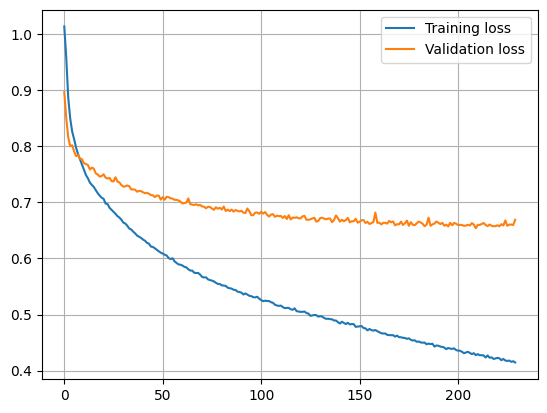

<ipython-input-22-3587fd0b847a>:21: RuntimeWarning: invalid value encountered in true_divide
  SPred = np.divide( SPred, mask )


In [24]:
nre='00' # training data
nre2='00' # predict data
batchsize = 64
nlayer=0  # training layer
nl=0  # noise level

fileloc=data_dir+'preds/'
if not os.path.exists(fileloc):
  os.mkdir(fileloc)

for kw in ['00']: # default setting
    if not os.path.exists(fileloc+kw):
        os.mkdir(fileloc+kw)
    filename=fileloc+'%s/'%(kw)

    for var1 in ['psi']:# "q","rel"
        for vn in ['div']:#'div','uvq','grad'
              for f in ['empb']:# "em","eb"
                    for rni in range(30,31):  # random seeds 30-50
                        print(kw,nre,var1,vn,f,rni)
                        if kw == '00':
                            input_d = get_data(read_data(var1,nlayer,nre,f))
                            if vn == 'div':
                                empb = get_data(read_data(vn,nlayer,nre,f))
                            else:
                                gd_u = get_data(read_data(vn,nlayer,nre,f)[0])
                                gd_v = get_data(read_data(vn,nlayer,nre,f)[1])
                        else:
                            print('non')

                        if vn == 'div':
                            if not os.path.exists(filename+'%s/Pr_%s_%s_%s_%s_%s.npy'%(nlayer,vn,f,nre2,var1,rni)):
                                train_loader,val_loader, scalings=load_dataT(input_d,empb,rni,batchsize)
                                model = train_model(n_feature=1,n_out=1).to(device)
                                trainig_process(model,train_loader,val_loader)
                                if not os.path.exists(filename+'models'):
                                    os.mkdir(filename+'models')
                                #torch.save(model, filename+'models/%s_%s_%s_%s.pth'%(vn,f,var1,rni))

                                for nly in range(1):
                                    input_t = read_data(var1,nly,nre2,f)
                                    Spr=makePreds_1to1_all(input_t,scalings,model)
                                    if not os.path.exists(filename+'%s'%(nly)):
                                        os.mkdir(filename+'%s'%(nly))
                                    np.save(filename+'%s/Pr_%s_%s_%s_%s_%s'%(nly,vn,f,nre2,var1,rni),Spr)
                        else:
                            if not os.path.exists(filename+'%s/Pr_%s_%s_%s_%s_%s.npz'%(nlayer,vn,f,nre2,var1,rni)):
                                train_loader,val_loader, scalings1,scalings2=load_dataT2(input_d,gd_u,gd_v,rni,batchsize)
                                model2 = train_model(n_feature=1,n_out=2).to(device)
                                trainig_process(model2,train_loader,val_loader)
                                if not os.path.exists(filename+'models'):
                                    os.mkdir(filename+'models')
                                #torch.save(model2, filename+'models/%s_%s_%s_%s.pth'%(vn,f,var1,rni))

                                for nly in range(1):
                                    input_t = read_data(var1,nly,nre2,f)
                                    Spr_u,Spr_v=makePreds_1to2_all(input_t,scalings1,scalings2,model2)
                                    if not os.path.exists(filename+'%s'%(nly)):
                                        os.mkdir(filename+'%s'%(nly))
                                    np.savez(filename+'%s/Pr_%s_%s_%s_%s_%s'%(nly,vn,f,nre2,var1,rni),Spr_u,Spr_v)

# one input with noise

00 00 psi div empb 30 0.3
Validation loss decreased (inf --> 0.977832).  Saving model ...
Epoch :  1 	 loss : 1.007630855590105 loss_val : 0.9778317153453827
Validation loss decreased (0.977832 --> 0.974036).  Saving model ...
Epoch :  2 	 loss : 1.0037577599287033 loss_val : 0.9740359783172607
Validation loss decreased (0.974036 --> 0.965281).  Saving model ...
Epoch :  3 	 loss : 0.9947006039321422 loss_val : 0.9652814984321594
Validation loss decreased (0.965281 --> 0.963339).  Saving model ...
Epoch :  4 	 loss : 0.9851163975894451 loss_val : 0.9633387058973313
Validation loss decreased (0.963339 --> 0.961919).  Saving model ...
Epoch :  5 	 loss : 0.981408878415823 loss_val : 0.9619192242622375
Validation loss decreased (0.961919 --> 0.960165).  Saving model ...
Epoch :  6 	 loss : 0.9785575114190579 loss_val : 0.96016546189785
Validation loss decreased (0.960165 --> 0.958859).  Saving model ...
Epoch :  7 	 loss : 0.9771972894668579 loss_val : 0.9588591188192368
Validation loss d

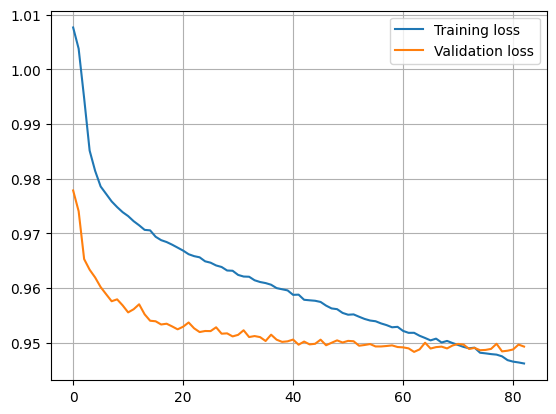

<ipython-input-15-b6bf347978df>:21: RuntimeWarning: invalid value encountered in true_divide
  SPred = np.divide( SPred, mask )


In [ ]:
# noise(eddy flux)
nre='00' # training data
nre2='00' # predict data
batchsize = 64
nlayer=0 # training layer
fileloc=data_dir+'preds/'

for kw in ['00']:
    if not os.path.exists(fileloc+kw):
        os.mkdir(fileloc+kw)
    filename=fileloc+'%s/'%(kw)

    for noise_level in [0.3,0.6,0.9,1.2]:
        for vn in ['div','uvq','grad']:#
            for f in ['empb','em','eb']:#
                for rni in range(30,50):
                    var1='psi'
                    print(kw,nre,var1,vn,f,rni,noise_level)
                    if kw == '00':
                        input_d = get_data(read_data(var1,nlayer,nre,f,noise_level))
                        if vn == 'div':
                            empb = get_data(read_data(vn,nlayer,nre,f,noise_level))
                        else:
                            gd_u = get_data(read_data(vn,nlayer,nre,f,noise_level)[0])
                            gd_v = get_data(read_data(vn,nlayer,nre,f,noise_level)[1])
                    else:
                        print('non')

                    if vn == 'div':
                        if not os.path.exists(filename+'%s/Pr_%s_%s_%s_%s_%s_%s.npy'%(nlayer,vn,f,nre2,var1,rni,"{:02}".format(int(noise_level * 10)))):
                            train_loader,val_loader, scalings=load_dataT(input_d,empb,rni,batchsize)
                            model = train_model(n_feature=1,n_out=1).to(device)
                            trainig_process(model,train_loader,val_loader)

                            for nly in range(1):
                                input_t = read_data(var1,nly,nre2,f,noise_level)
                                Spr=makePreds_1to1_all(input_t,scalings,model)
                                if not os.path.exists(filename+'%s'%(nly)):
                                    os.mkdir(filename+'%s'%(nly))
                                np.save(filename+'%s/Pr_%s_%s_%s_%s_%s_%s'%(nly,vn,f,nre2,var1,rni,"{:02}".format(int(noise_level * 10))),Spr)
                    else:
                        if not os.path.exists(filename+'%s/Pr_%s_%s_%s_%s_%s_%s.npz'%(nlayer,vn,f,nre2,var1,rni,"{:02}".format(int(noise_level * 10)))):
                            train_loader,val_loader, scalings1,scalings2=load_dataT2(input_d,gd_u,gd_v,rni,batchsize)
                            model2 = train_model(n_feature=1,n_out=2).to(device)
                            trainig_process(model2,train_loader,val_loader)

                            for nly in range(1):
                                input_t = read_data(var1,nly,nre2,f,noise_level)
                                Spr_u,Spr_v=makePreds_1to2_all(input_t,scalings1,scalings2,model2)
                                if not os.path.exists(filename+'%s'%(nly)):
                                    os.mkdir(filename+'%s'%(nly))
                                np.savez(filename+'%s/Pr_%s_%s_%s_%s_%s_%s'%(nly,vn,f,nre2,var1,rni,"{:02}".format(int(noise_level * 10))),Spr_u,Spr_v)

# plot

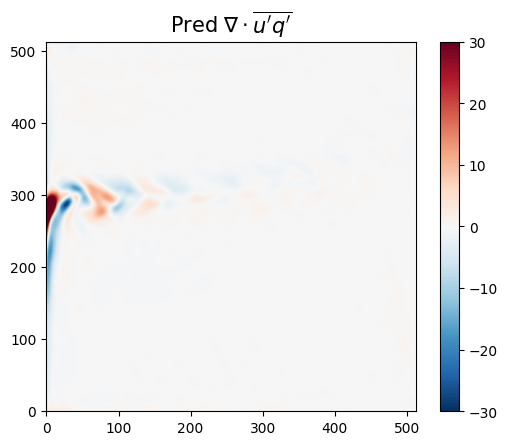

In [25]:
lm=30
plt.imshow(Spr,origin='lower',cmap='RdBu_r',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'Pred $ \nabla \cdot \overline{u^{\prime} q^{\prime}} $',fontsize=15)